# Imports and Global Variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
BASEDIR='/content/drive/My Drive/Colab Notebooks/Esoteric Bot/'
DATADIR = BASEDIR + 'DATA/'
PYTHONDIR = BASEDIR + 'PYTHON/'
RESULTSDIR = BASEDIR + 'RESULTS/'
MODELSDIR = BASEDIR + 'MODELS/'

In [ ]:
import sys
sys.path.append(PYTHONDIR)

import os 
import pdb
import random

import numpy as np 
import pandas as pd 
from tqdm.notebook import tqdm

import torch
import torchvision 
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.models as models 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt


In [ ]:
TRAIN = False
TEST = True
assert TRAIN ^ TEST
image_size = (64,64)
num_channels = 3
latent_dim = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
if TRAIN:
    BATCH_SIZE = 128
if TEST:
    num_imgs_to_generate = 128


In [ ]:
device = get_default_device()
print(device)

cuda


# Functions

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
    
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def save_samples(index, latent_tensors, show=False):
    fake_images = generator.forward(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(RESULTSDIR+'SAMPLES/', fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(BATCH_SIZE, latent_dim, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(BATCH_SIZE, latent_dim, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(BATCH_SIZE, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        cumul_loss_d = 0
        cumul_loss_g = 0
        cumul_r_score = 0
        cumul_f_score = 0
        for real_images, _ in tqdm(dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            cumul_loss_g += loss_g 
            cumul_loss_d += loss_d
            cumul_r_score += real_score 
            cumul_f_score += fake_score
            
        # Record losses & scores
        num_batches = len(dl)
        losses_g.append(cumul_loss_g/num_batches)
        losses_d.append(cumul_loss_d/num_batches)
        real_scores.append(cumul_r_score/num_batches)
        fake_scores.append(cumul_f_score/num_batches)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, cumul_loss_g/num_batches, cumul_loss_d/num_batches, cumul_r_score/num_batches, cumul_f_score/num_batches))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

# Loading and preparing the data

In [ ]:
if TRAIN:
    transform_ds = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(*stats)
                                    ])

    images = torchvision.datasets.ImageFolder(root=DATADIR,transform=transform_ds)
    dl = DataLoader(images,BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)
    print(f"Number of images loaded: {len(images)}")
    example_img,_ = images[random.randint(0,len(images))]
    print(example_img.size())
    plt.imshow(example_img.permute(1,2,0))
    show_batch(dl)
    dl = DeviceDataLoader(dl, device)

# NN Classes


In [ ]:
if image_size[0] == 256:
    class DCGenerator(nn.Module):
        def __init__(self):
            super(ESOGenerator, self).__init__()

            def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
                block = [
                    nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                    nn.BatchNorm2d(n_output),
                    nn.ReLU(inplace=True),
                ]
                return block

            self.model = nn.Sequential(
                *convlayer(latent_dim, 1024, 4, 1, 0), # Fully connected layer via convolution.
                *convlayer(1024, 512, 4, 2, 1),
                *convlayer(512, 256, 4, 2, 1),
                *convlayer(256, 128, 4, 2, 1),
                *convlayer(128, 64, 4, 2, 1),
                *convlayer(64, 32, 4, 2, 1),
                nn.ConvTranspose2d(32, num_channels, 4, 2, 1),
                nn.Tanh()
            )

        def forward(self, z):
            z = z.view(-1, latent_dim, 1, 1)
            img = self.model(z)
            return img 
    class DCDiscriminator(nn.Module):
        def __init__(self):
            super(ESODiscriminator, self).__init__()

            def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=True):
                block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
                if bn:
                    block.append(nn.BatchNorm2d(n_output))
                block.append(nn.LeakyReLU(0.2, inplace=True))
                return block

            self.model = nn.Sequential(
                *convlayer(num_channels, 32, 4, 2, 1),
                *convlayer(32, 64, 4, 2, 1),
                *convlayer(64, 128, 4, 2, 1, bn=True),
                *convlayer(128, 256, 4, 2, 1, bn=True),
                *convlayer(256, 512, 4, 2, 1, bn=True),
                *convlayer(512, 1024, 4, 2, 1, bn=True),
                nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
                # nn.Flatten(),
                nn.Sigmoid()
            )

        def forward(self, imgs):
            critic_value = self.model(imgs)
            critic_value  = critic_value.view(imgs.size(0), -1)
            return critic_value
elif image_size[0] == 64:
    discriminator = nn.Sequential(
        # in: 3 x 64 x 64

        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 64 x 32 x 32

        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 128 x 16 x 16

        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 256 x 8 x 8

        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 512 x 4 x 4

        nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
        # out: 1 x 1 x 1

        nn.Flatten(),
        nn.Sigmoid())

    generator = nn.Sequential(
        # in: latent_size x 1 x 1

        nn.ConvTranspose2d(128, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # out: 512 x 4 x 4

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # out: 256 x 8 x 8

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # out: 128 x 16 x 16

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # out: 64 x 32 x 32

        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
        # out: 3 x 64 x 64
    )
else:
    sys.exit("Image size must be 64x64 or 256x256!")

# Training the model

In [ ]:
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)
if TRAIN:
    num_epochs = 150
    lr = 0.001
    fixed_latent = torch.randn(BATCH_SIZE, latent_dim, 1, 1, device=device)
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    print(generator)
    print(discriminator)

In [ ]:
if TRAIN:
    losses_g, losses_d, real_scores, fake_scores = fit(num_epochs,lr)
    torch.save(discriminator.state_dict(),MODELSDIR + f"discriminator_v{image_size[0]}4.ckpt")
    torch.save(generator.state_dict(),MODELSDIR + f"generator_v{image_size[0]}4.ckpt")

# Using the model

In [ ]:
if TEST:
    discriminator = to_device(discriminator, device)
    generator = to_device(generator, device)
    generator.load_state_dict(torch.load(MODELSDIR + f"generator_v{image_size[0]}3.ckpt"))
    discriminator.load_state_dict(torch.load(MODELSDIR + f"discriminator_v{image_size[0]}3.ckpt"))

torch.Size([128, 3, 64, 64])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


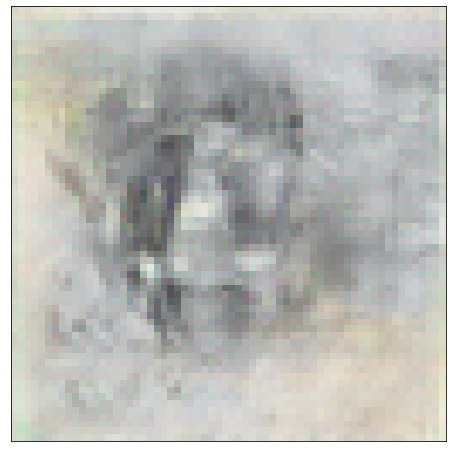

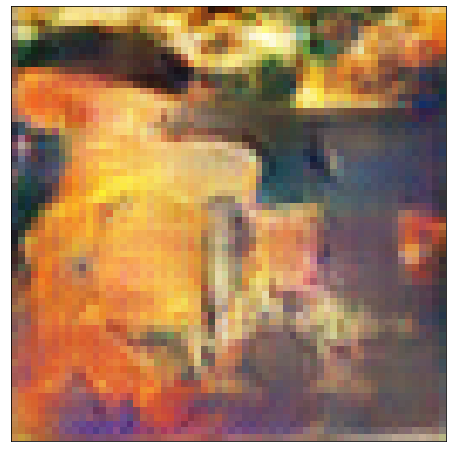

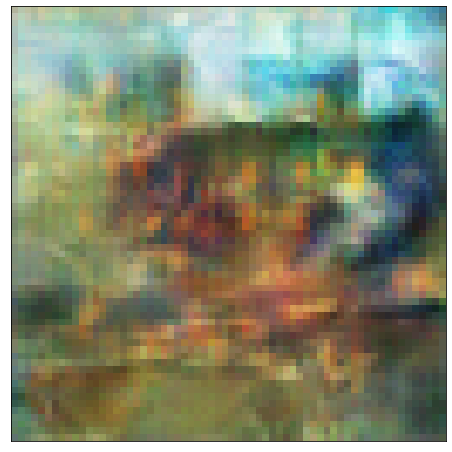

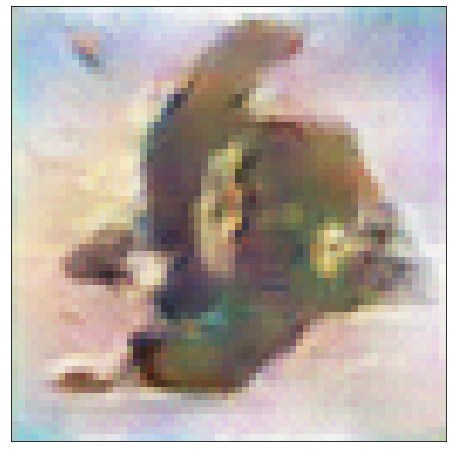

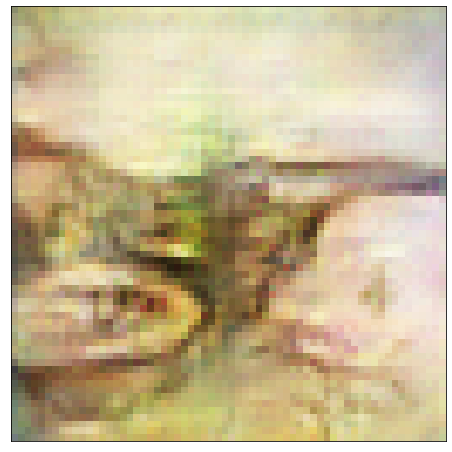

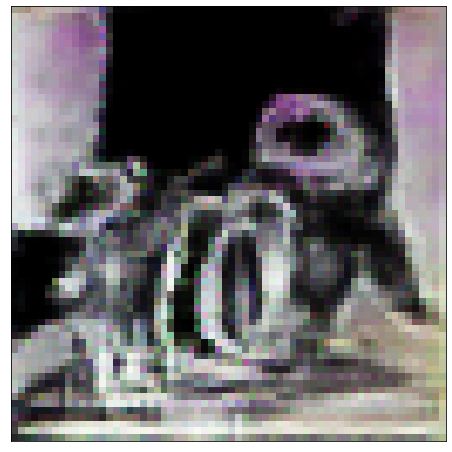

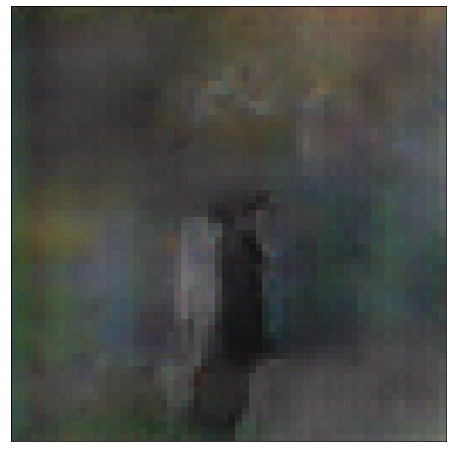

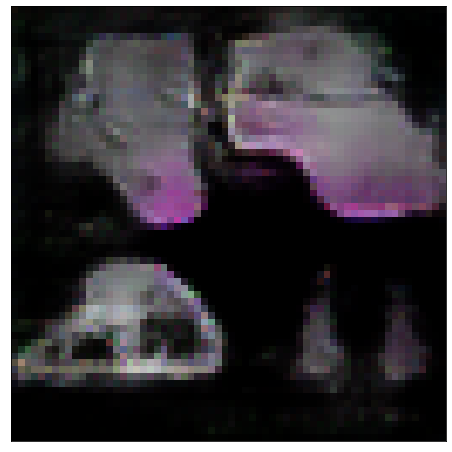

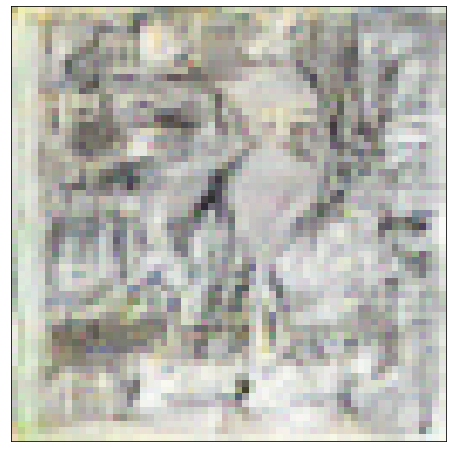

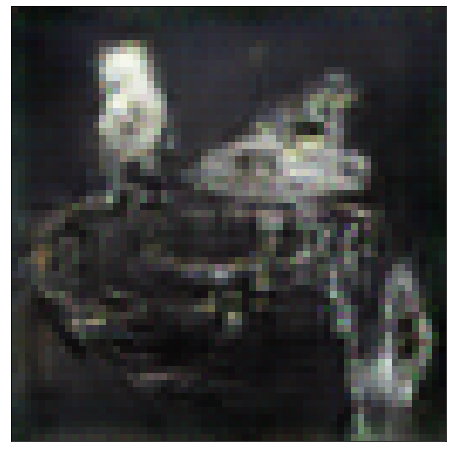

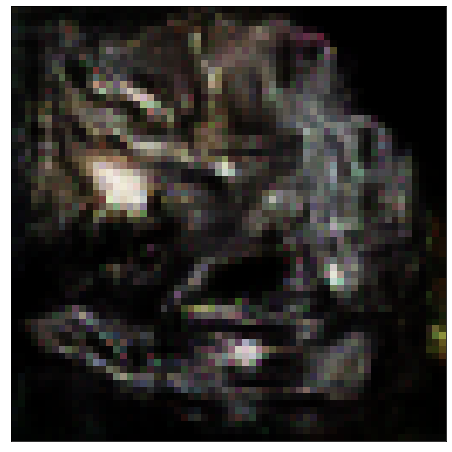

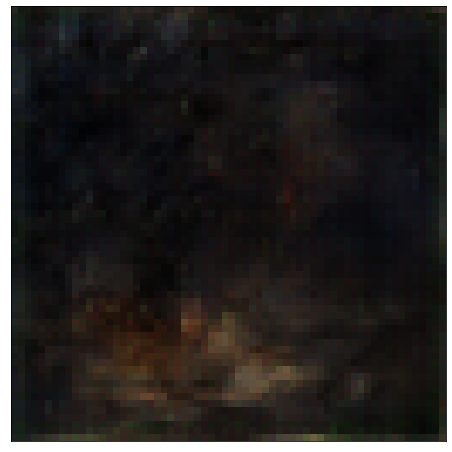

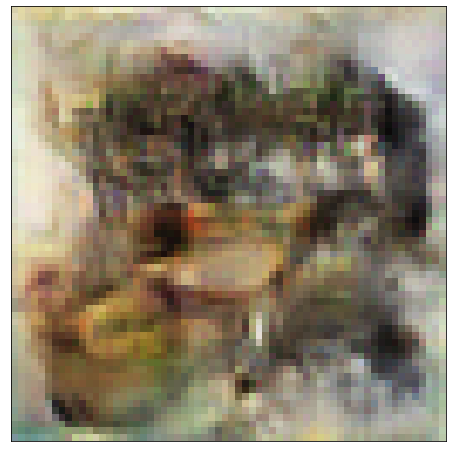

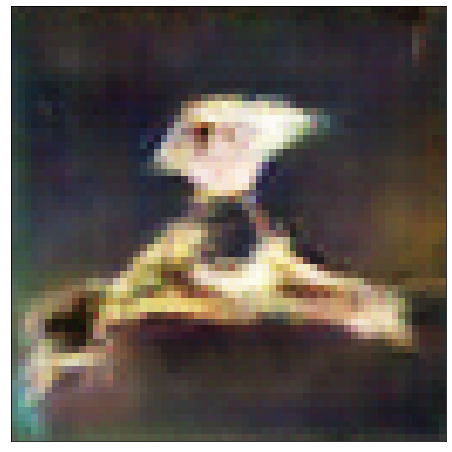

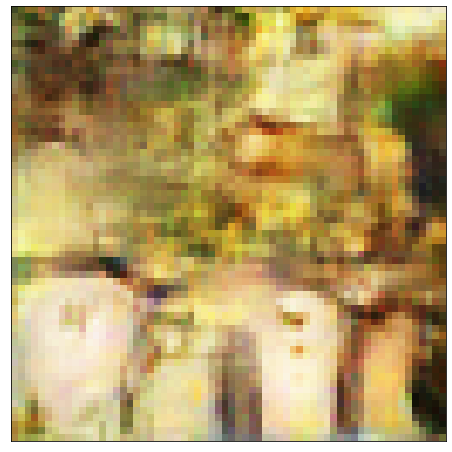

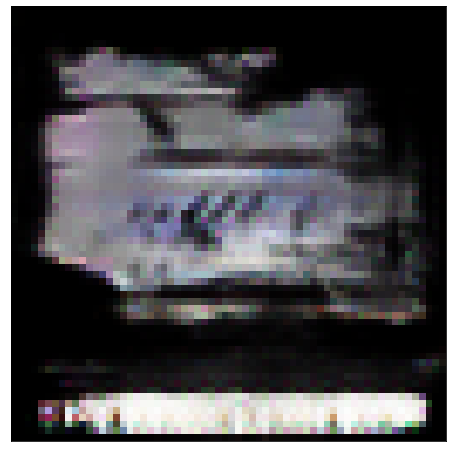

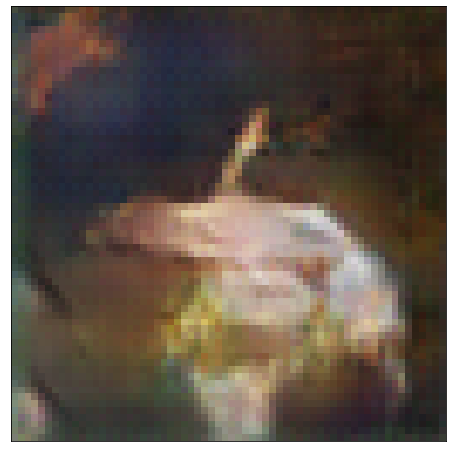

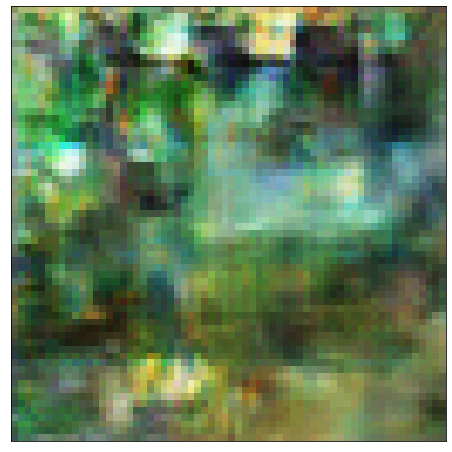

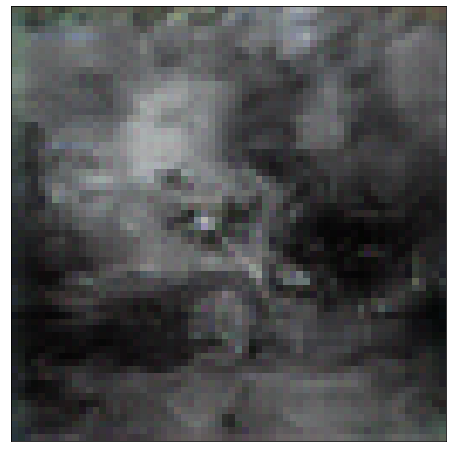

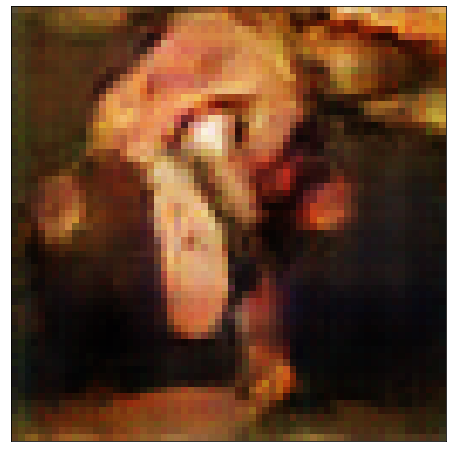

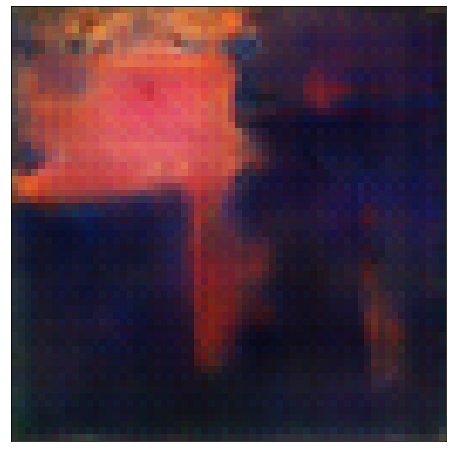

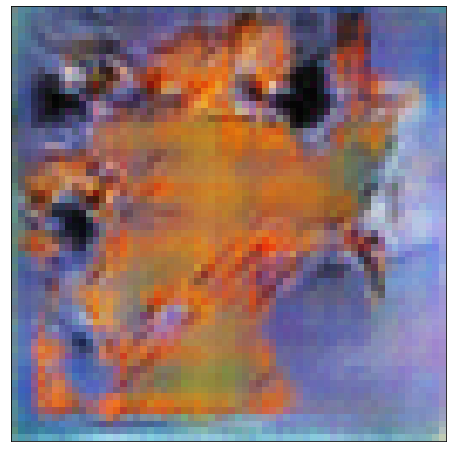

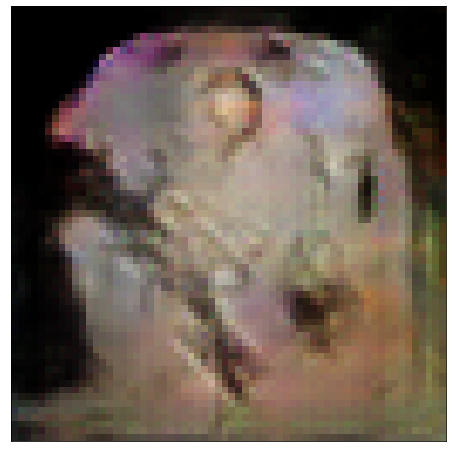

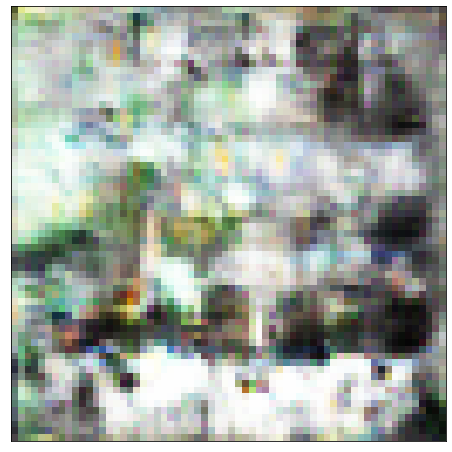

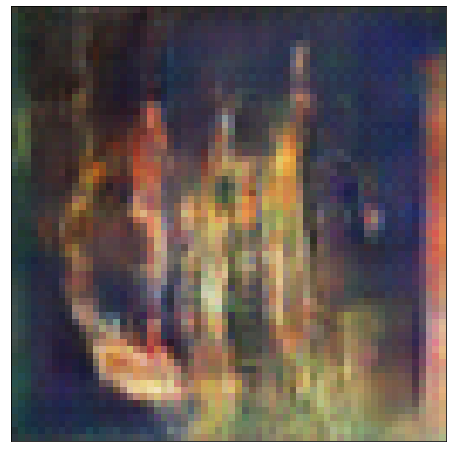

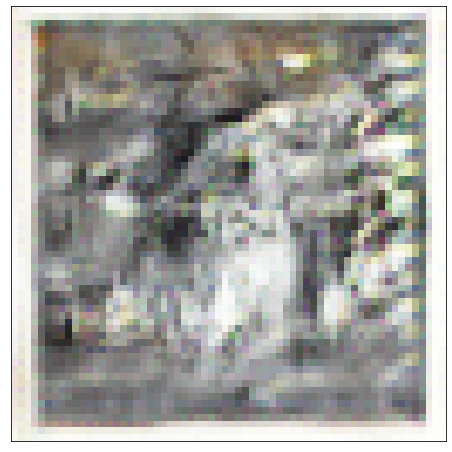

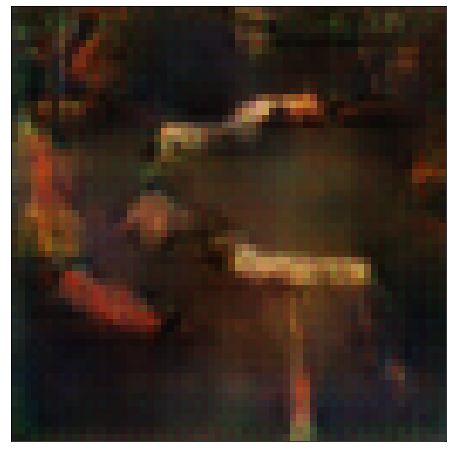

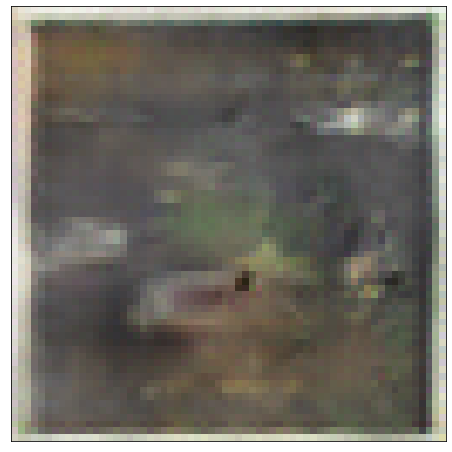

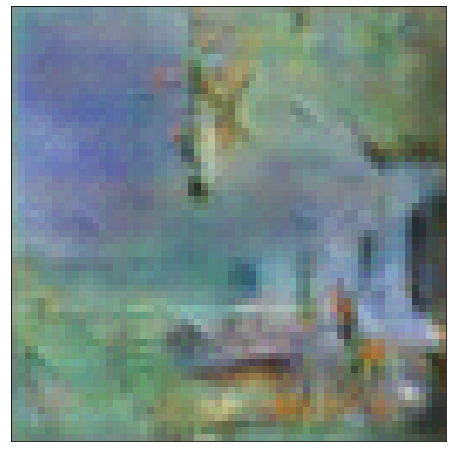

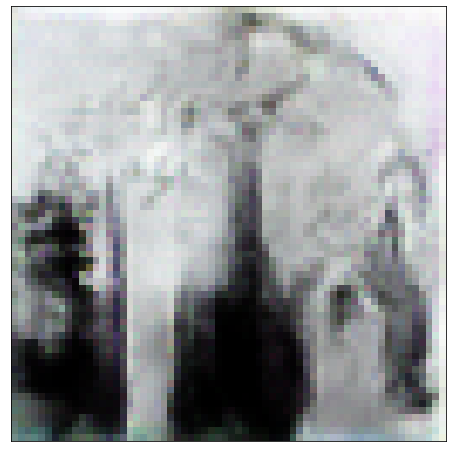

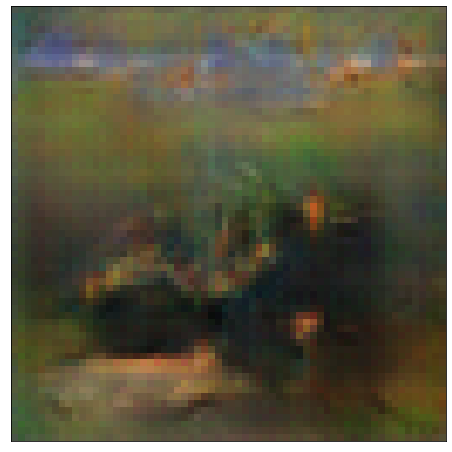

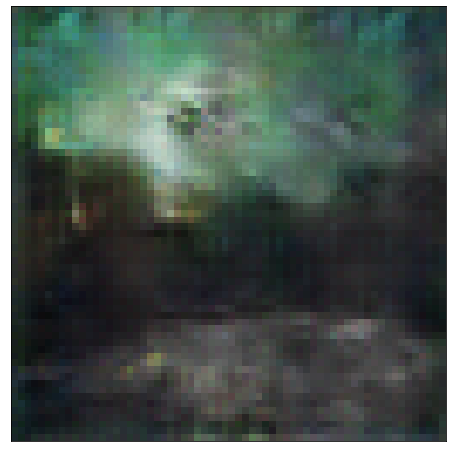

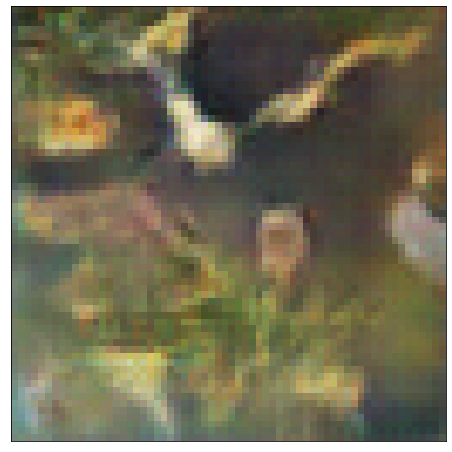

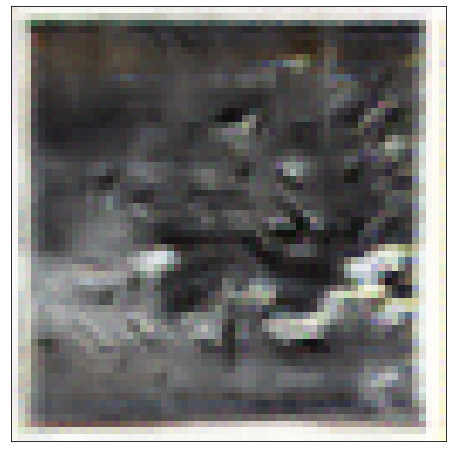

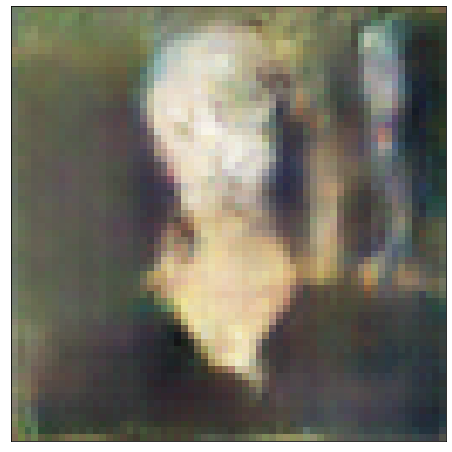

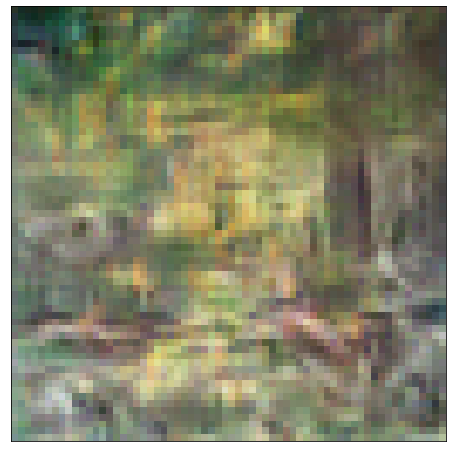

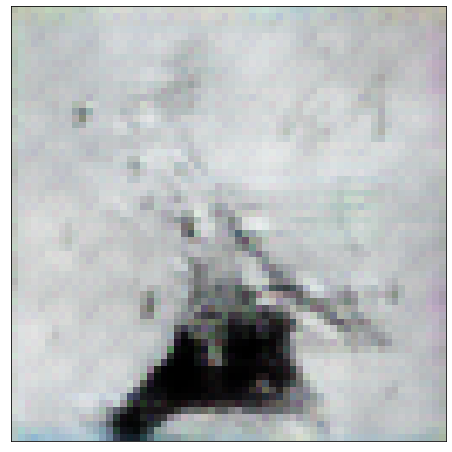

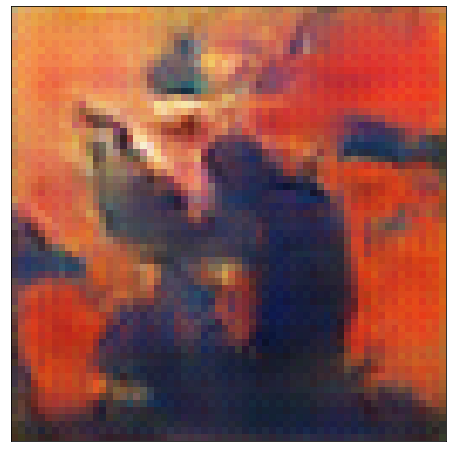

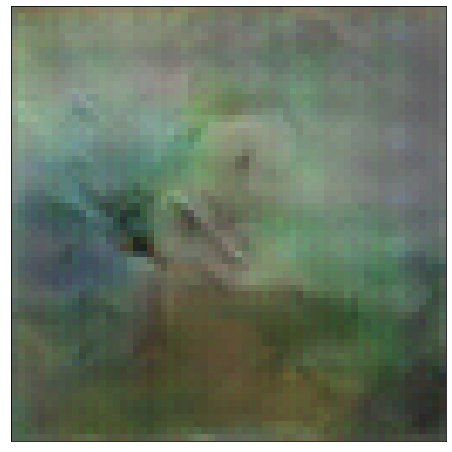

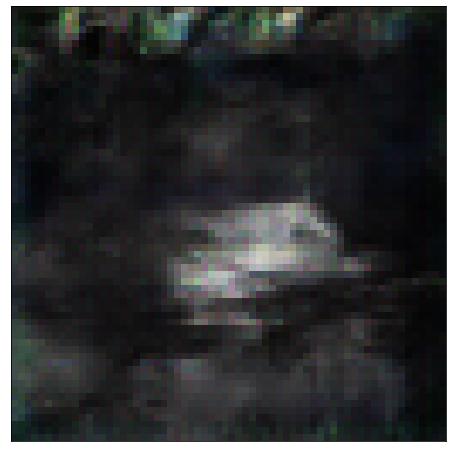

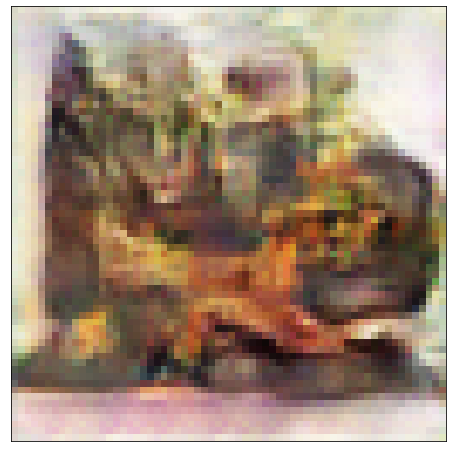

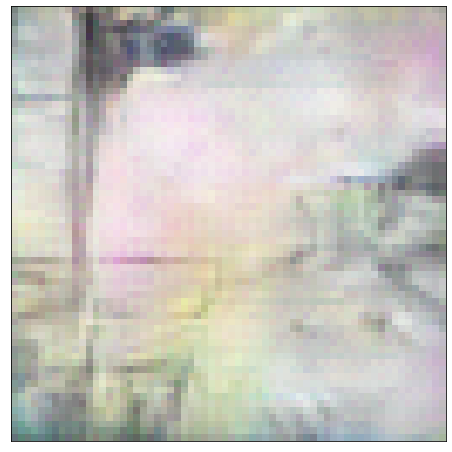

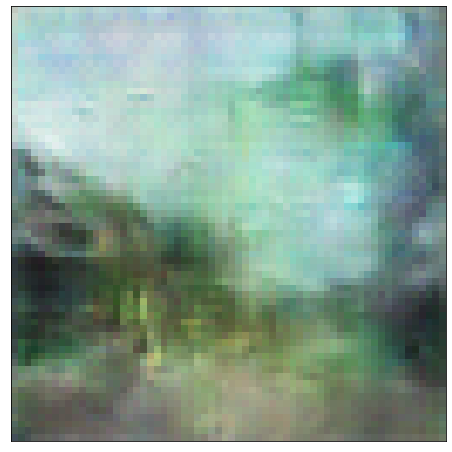

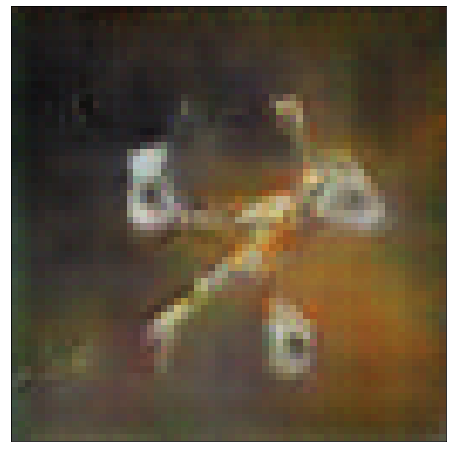

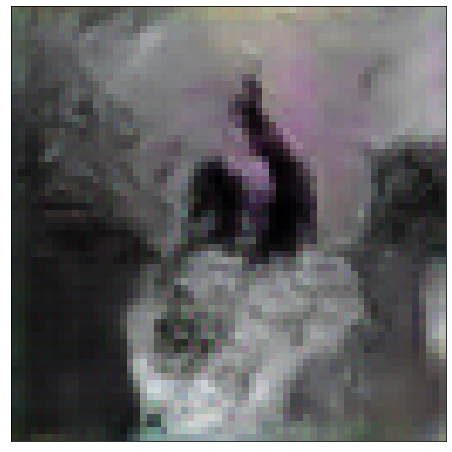

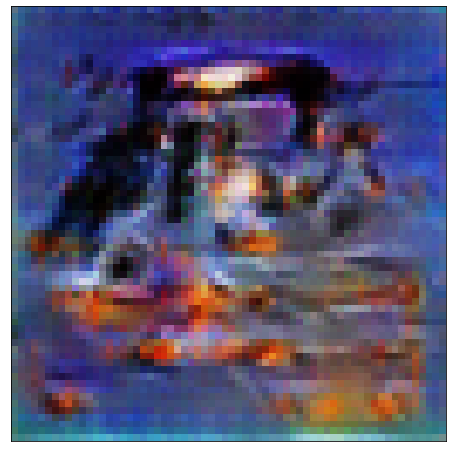

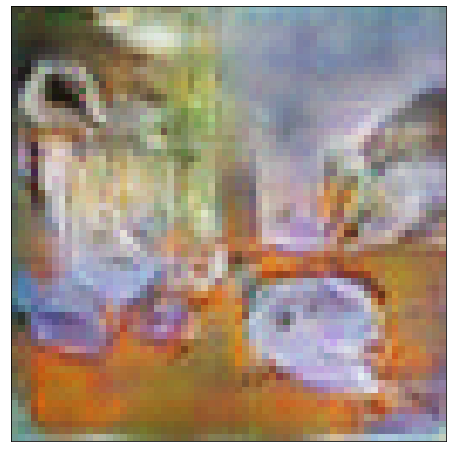

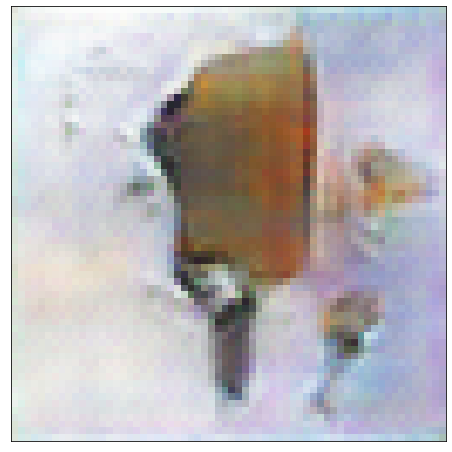

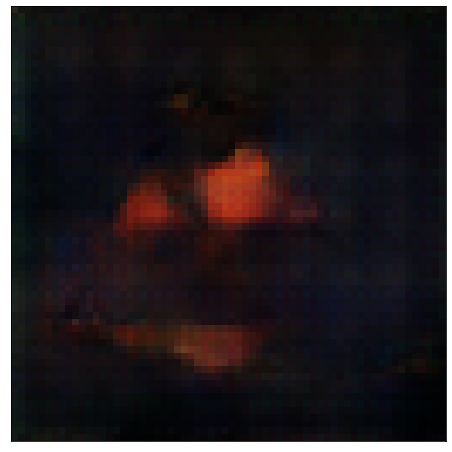

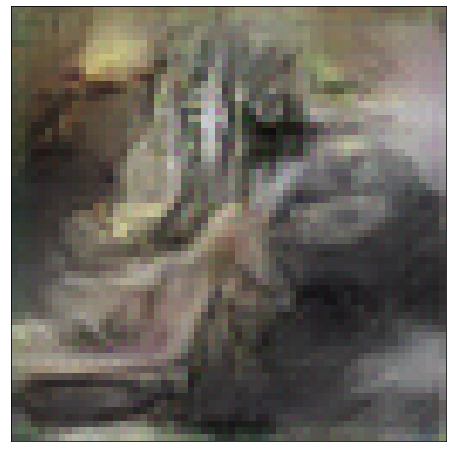

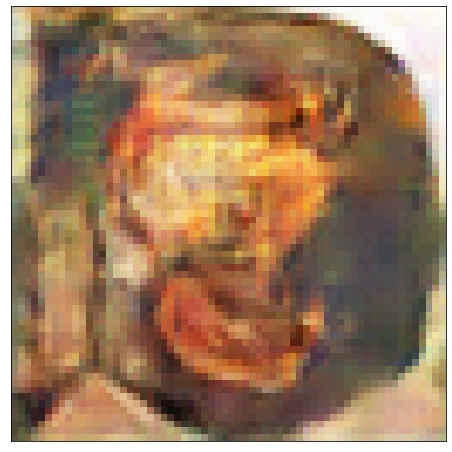

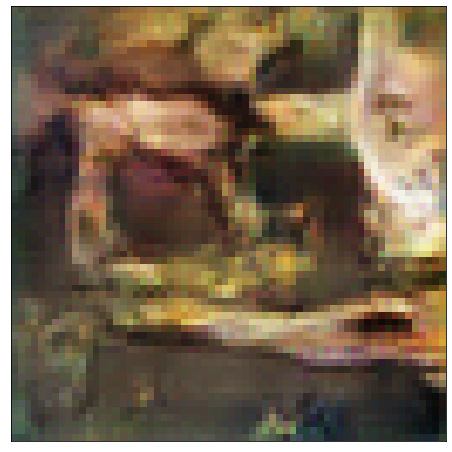

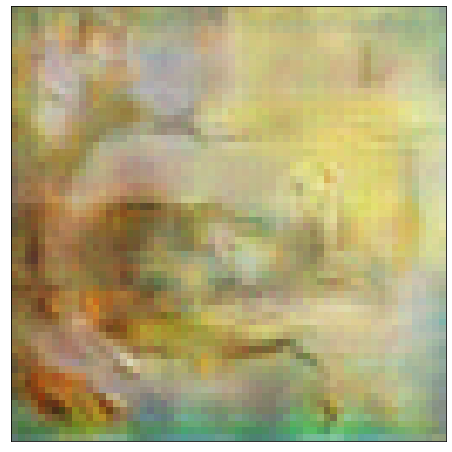

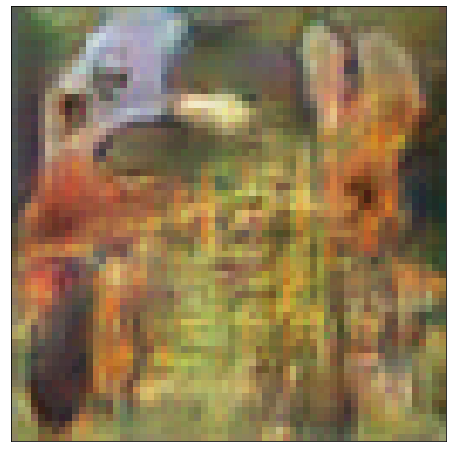

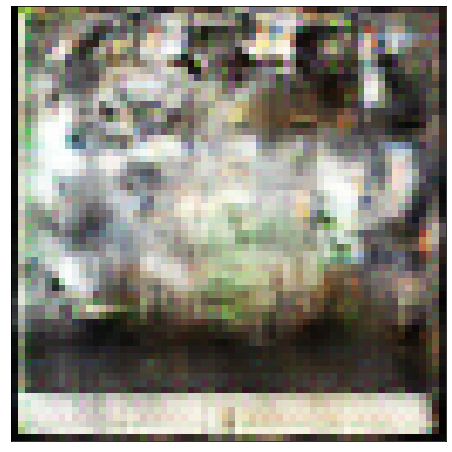

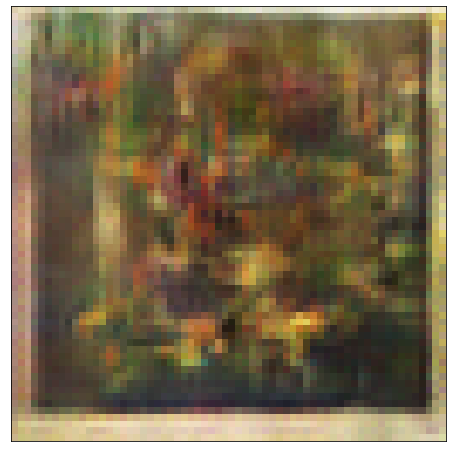

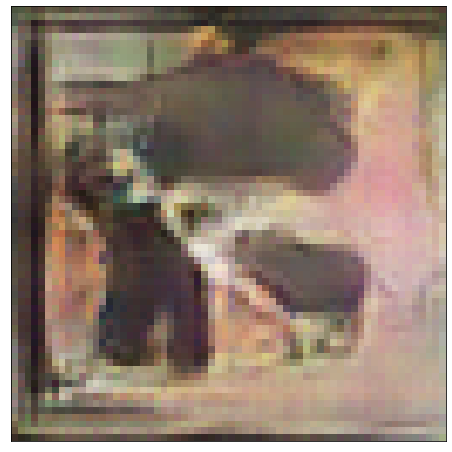

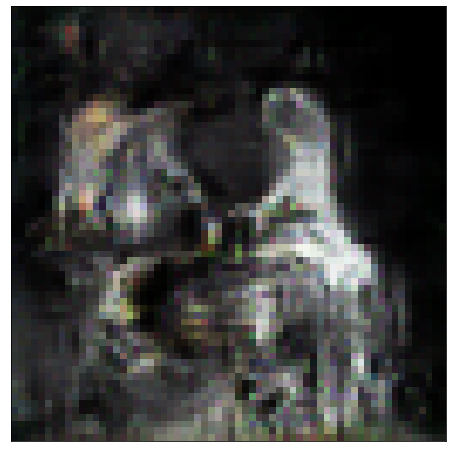

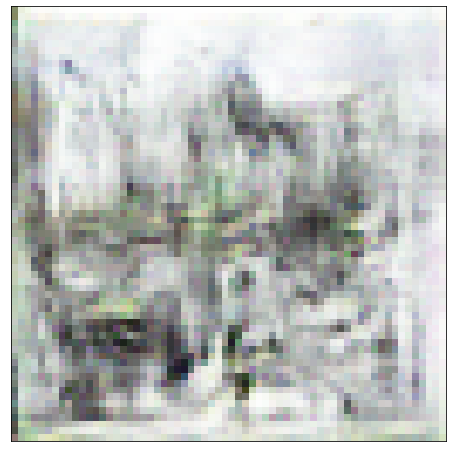

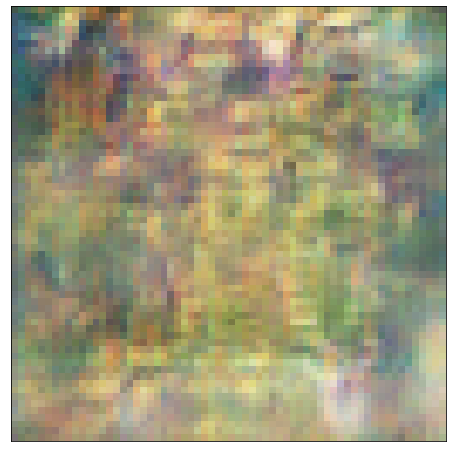

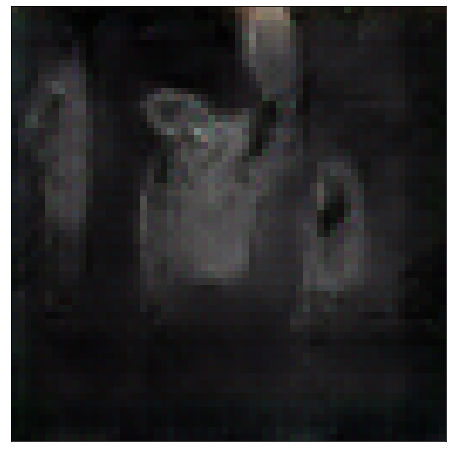

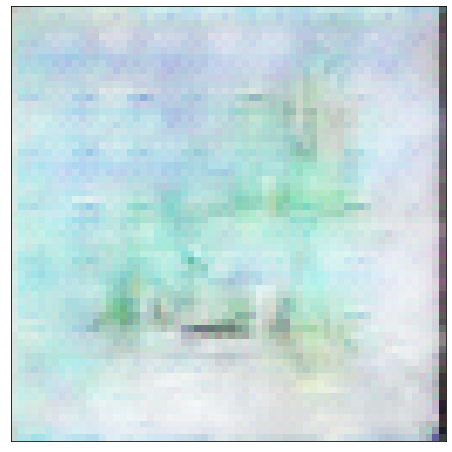

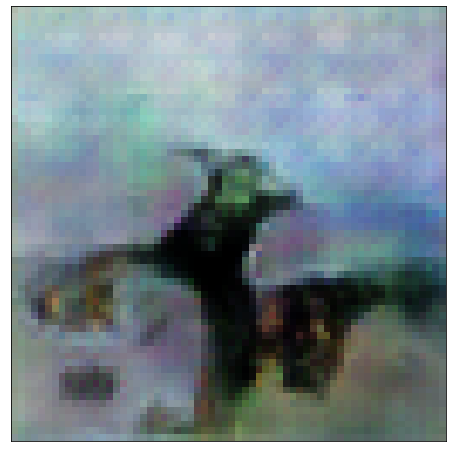

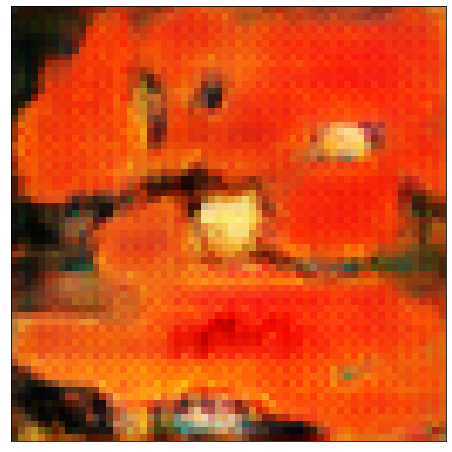

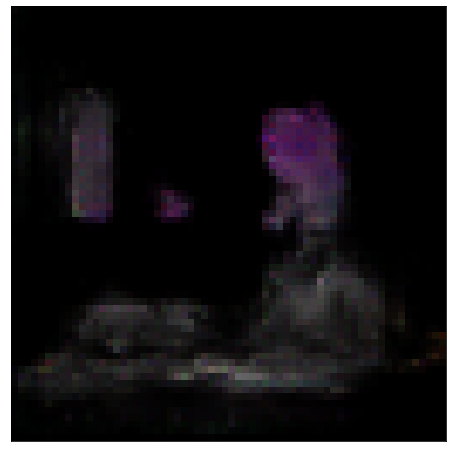

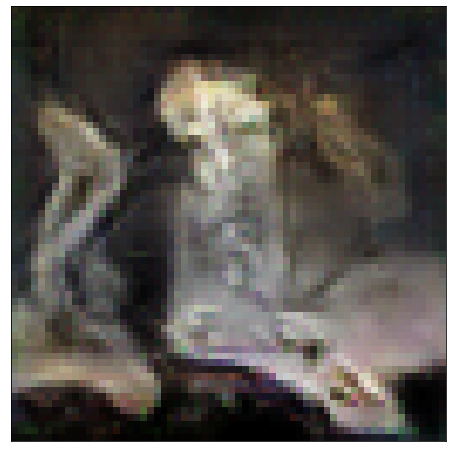

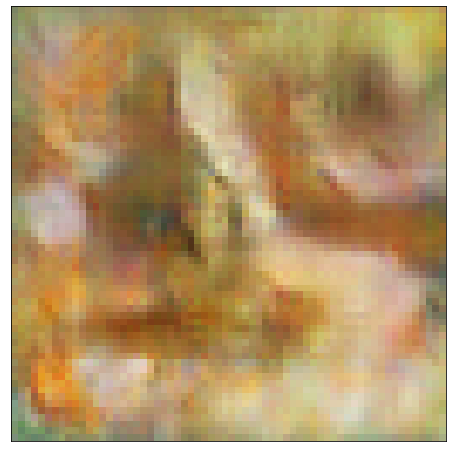

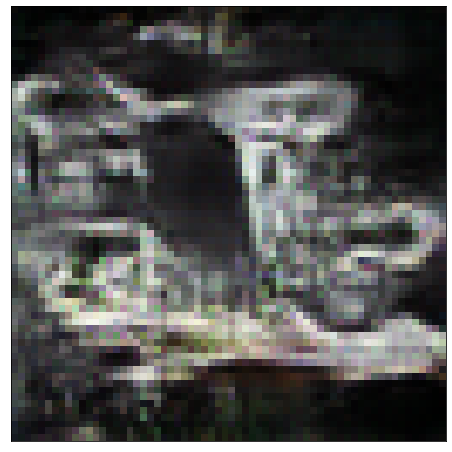

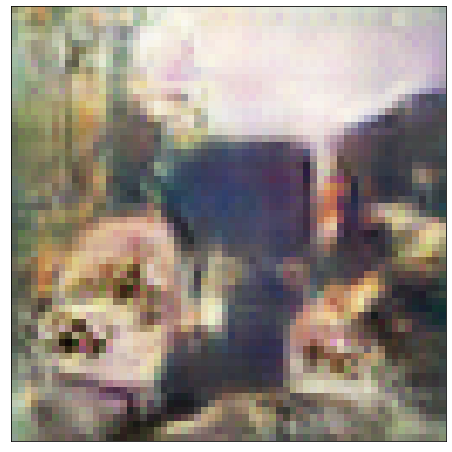

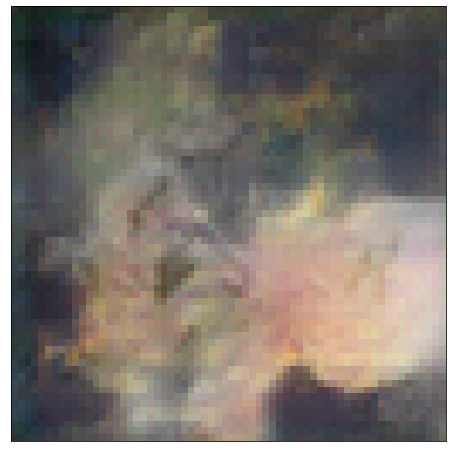

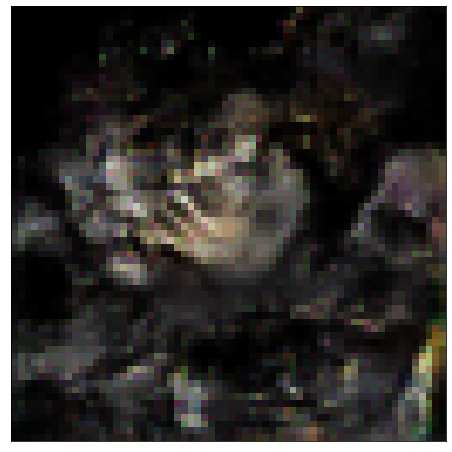

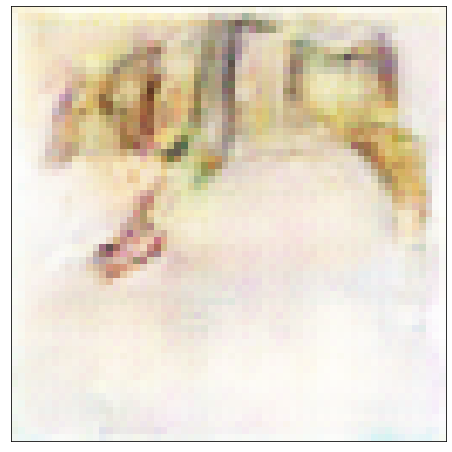

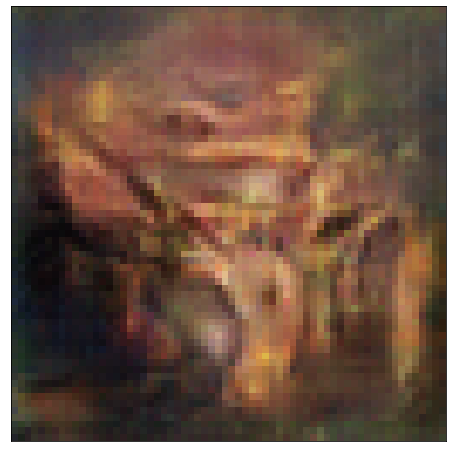

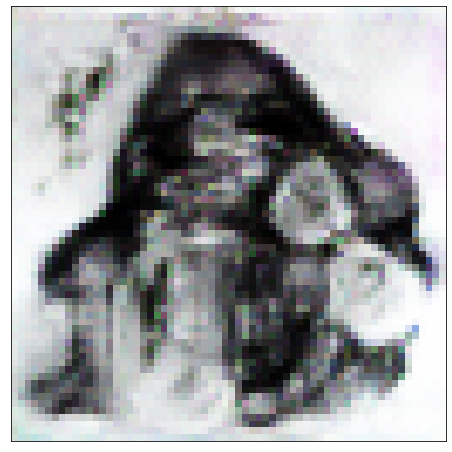

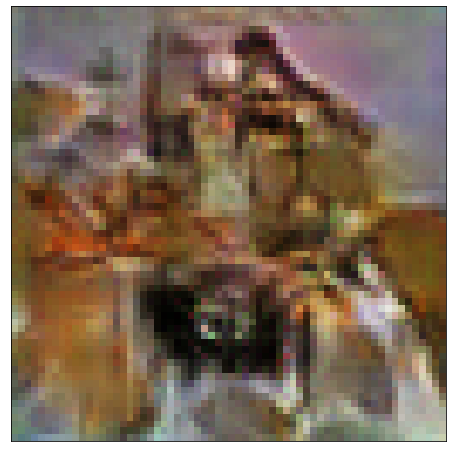

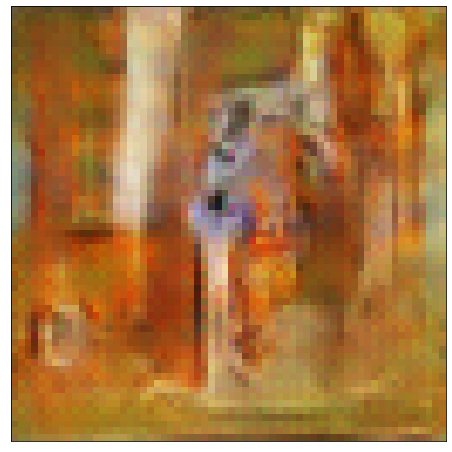

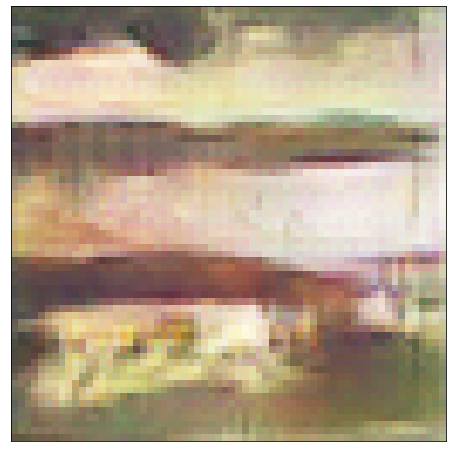

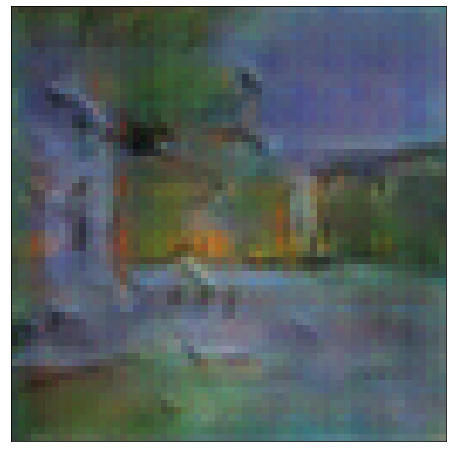

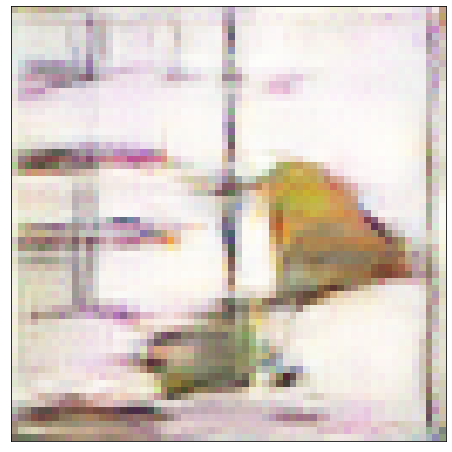

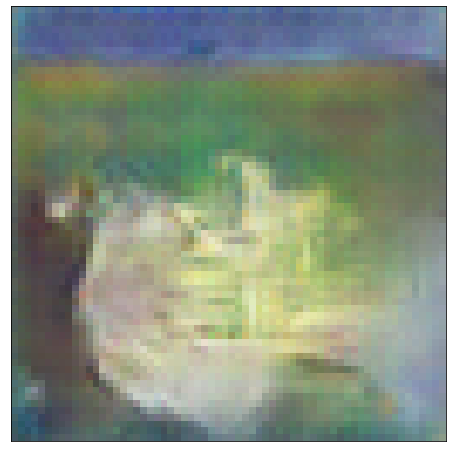

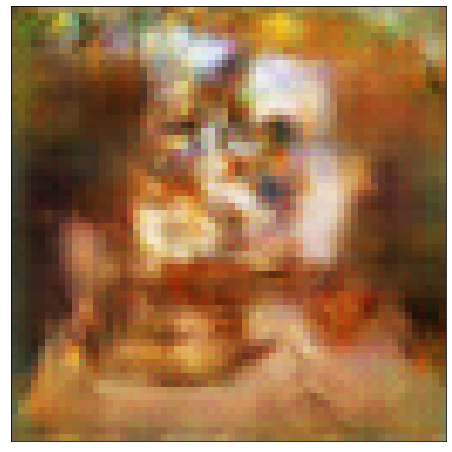

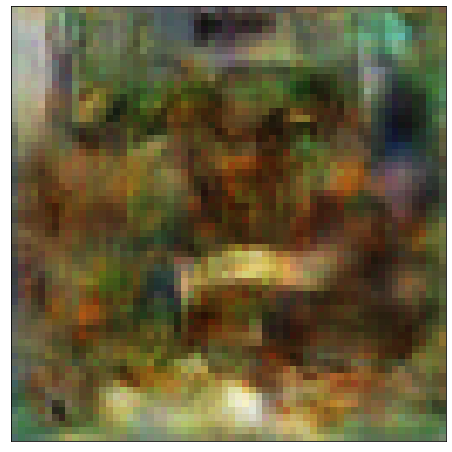

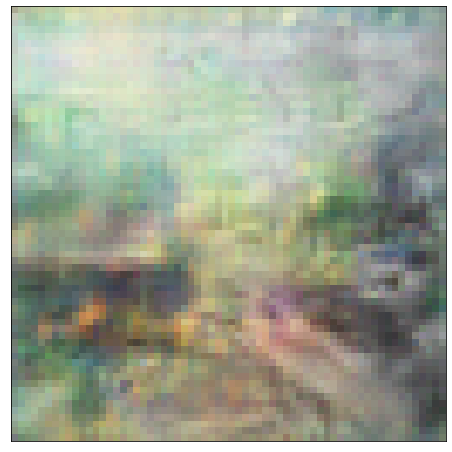

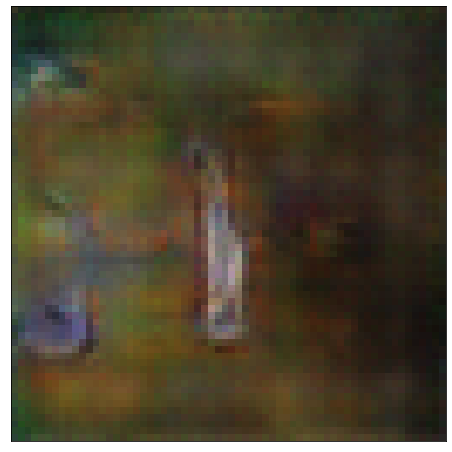

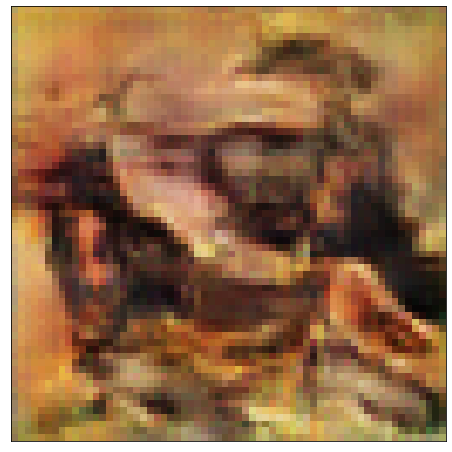

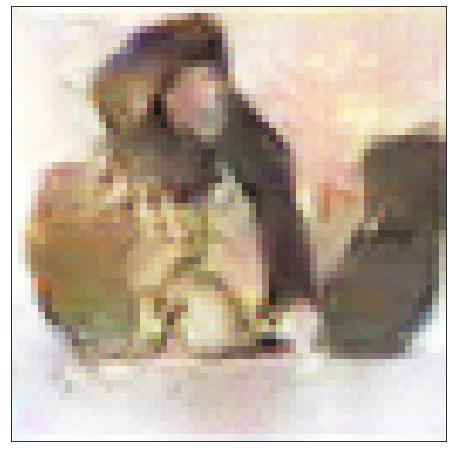

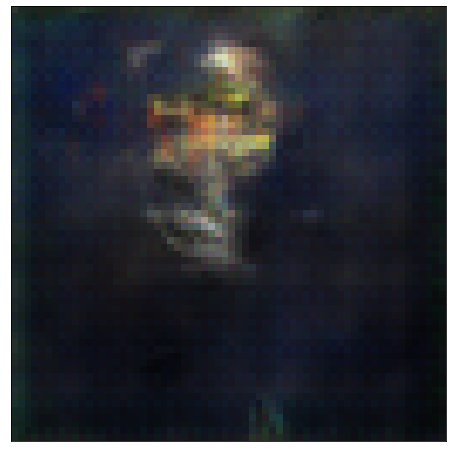

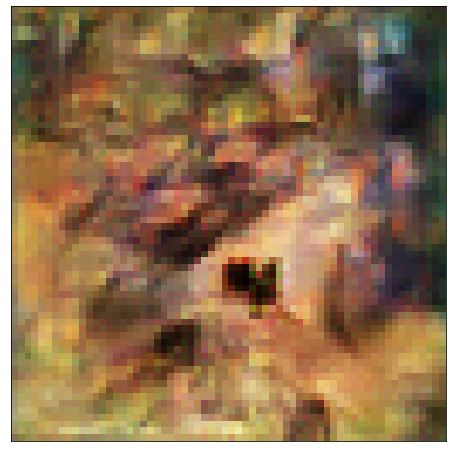

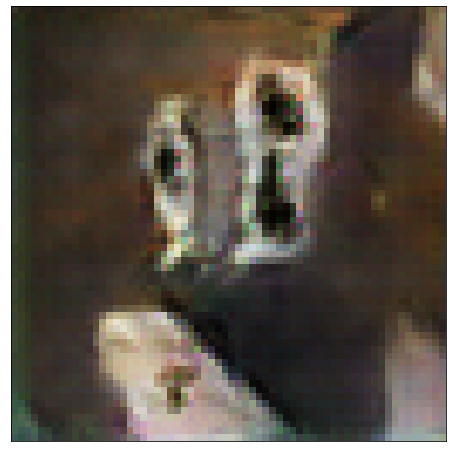

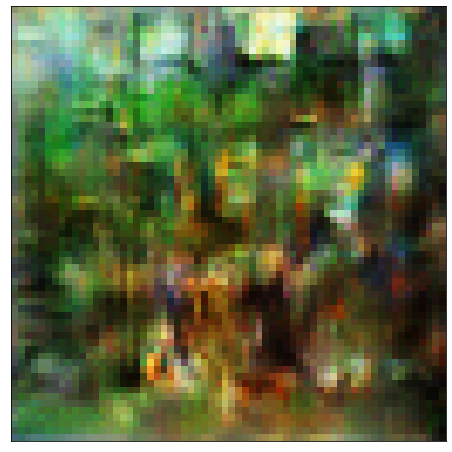

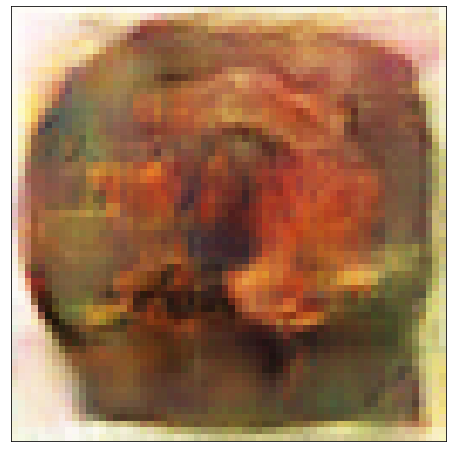

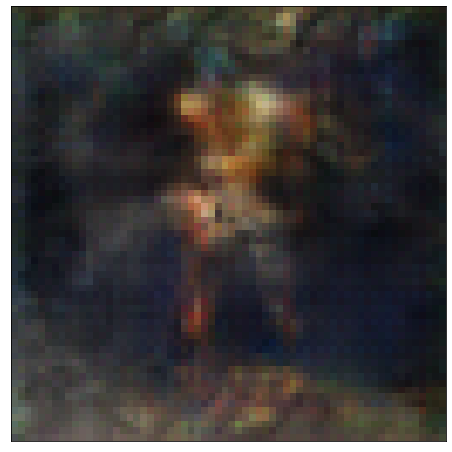

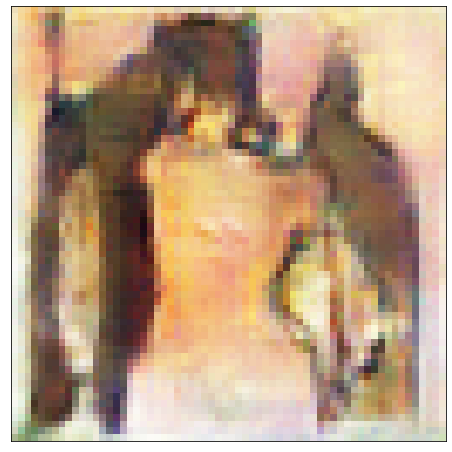

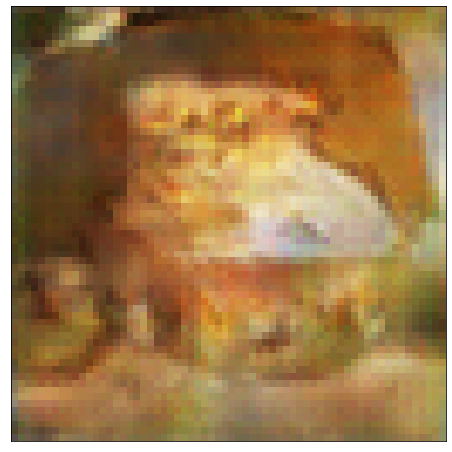

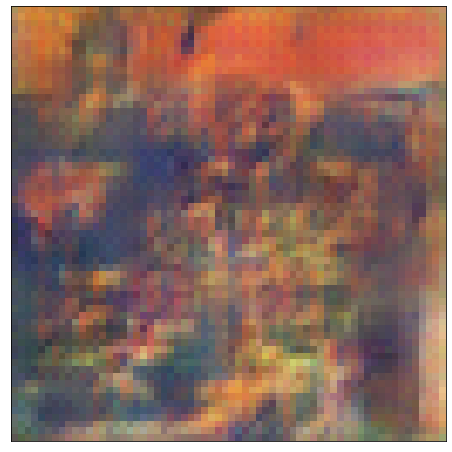

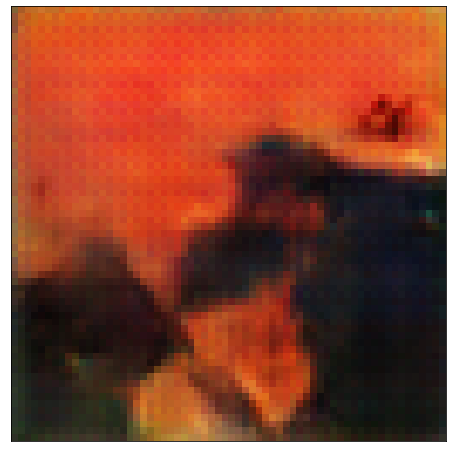

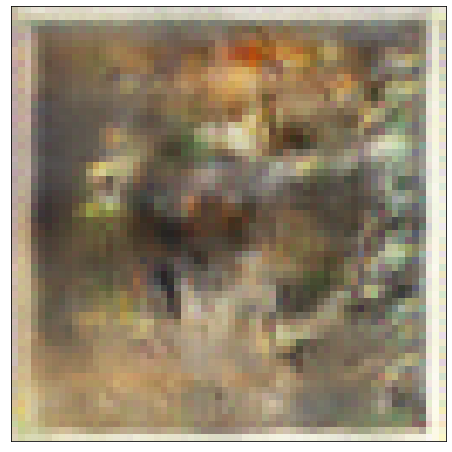

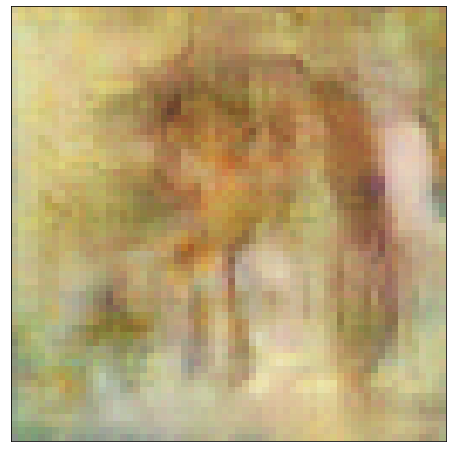

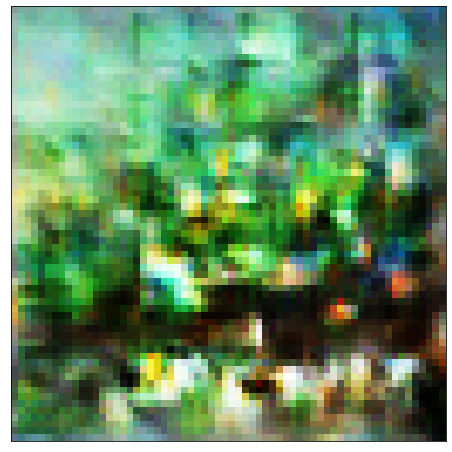

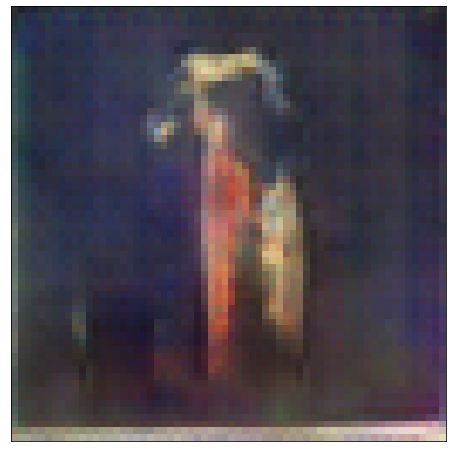

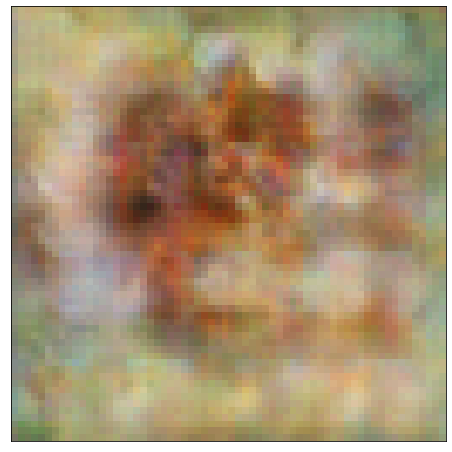

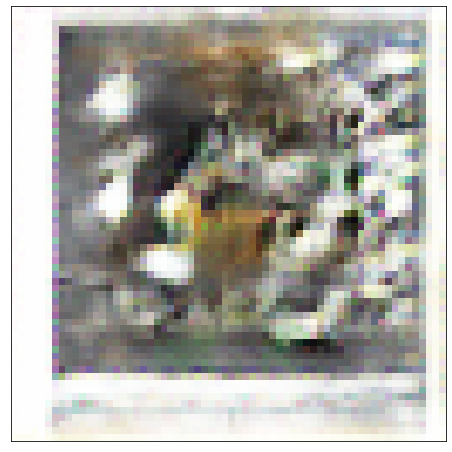

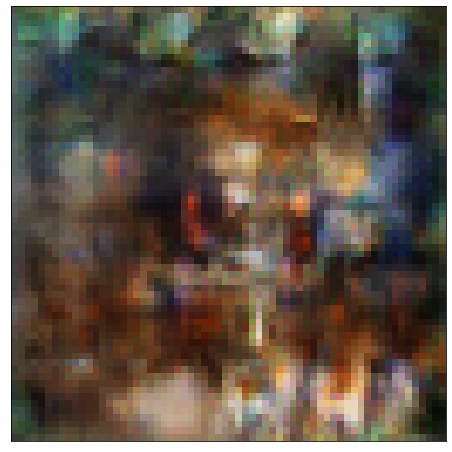

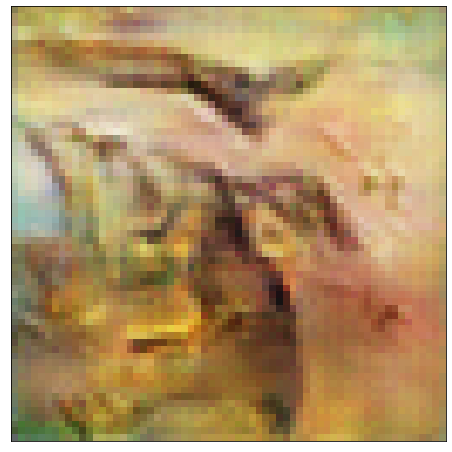

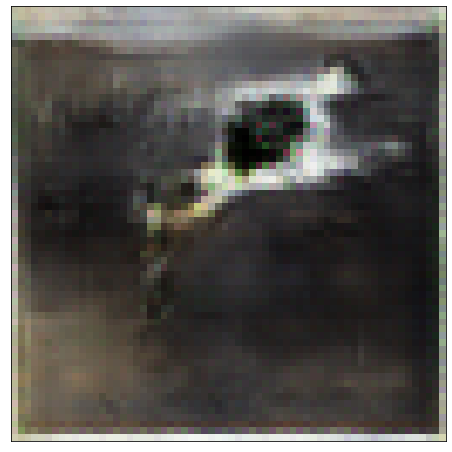

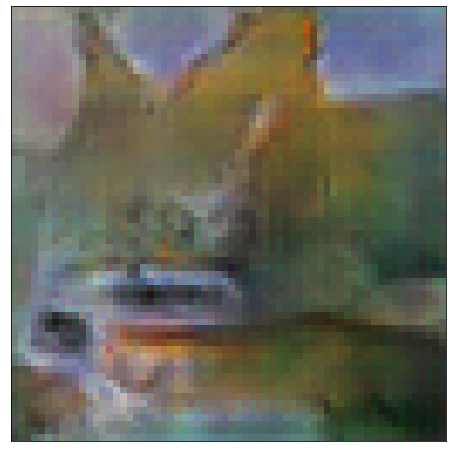

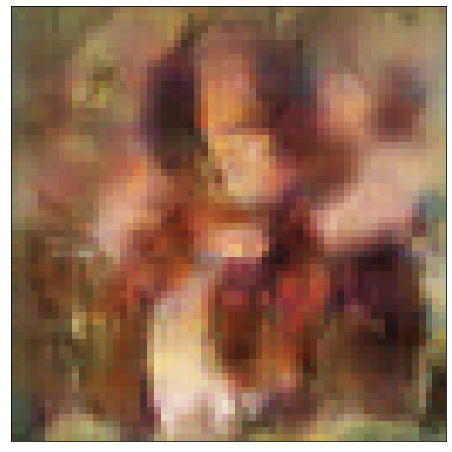

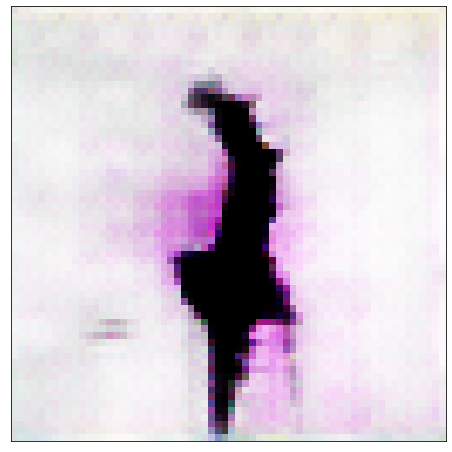

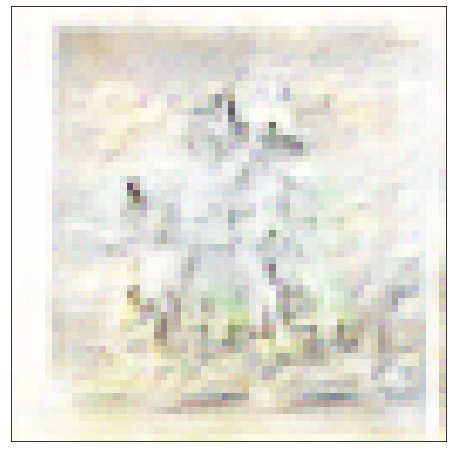

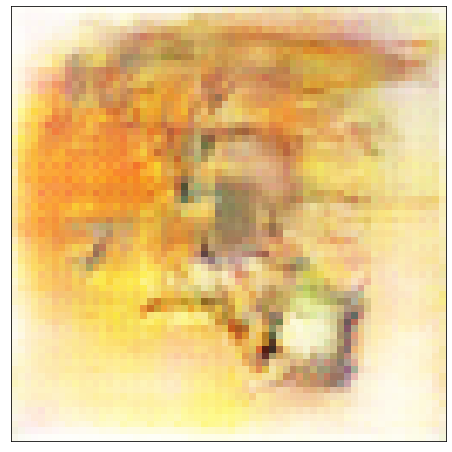

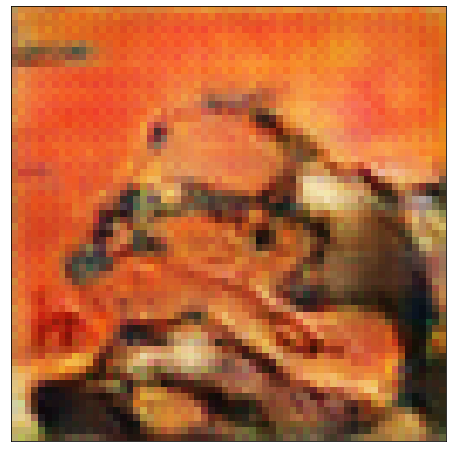

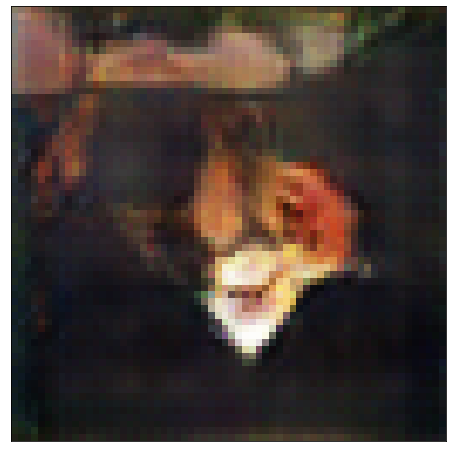

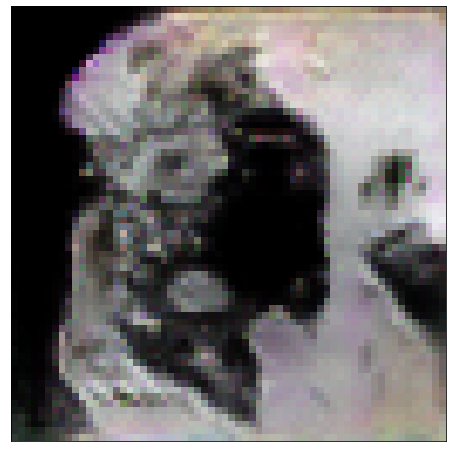

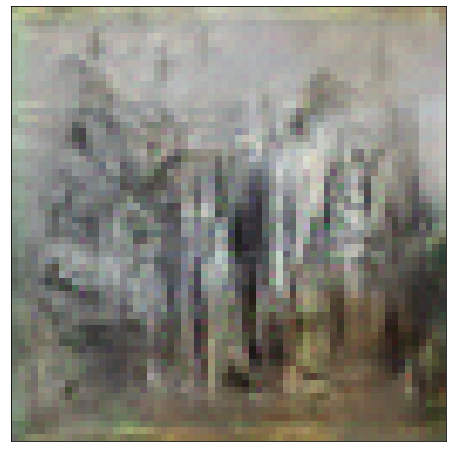

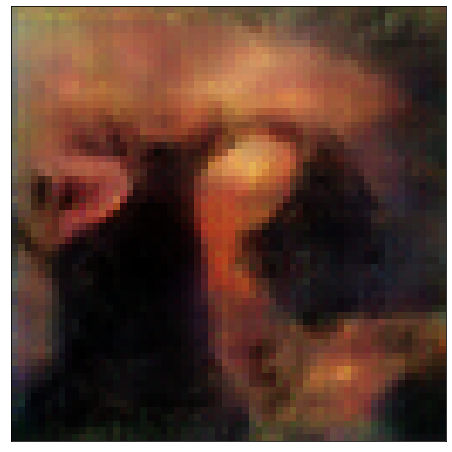

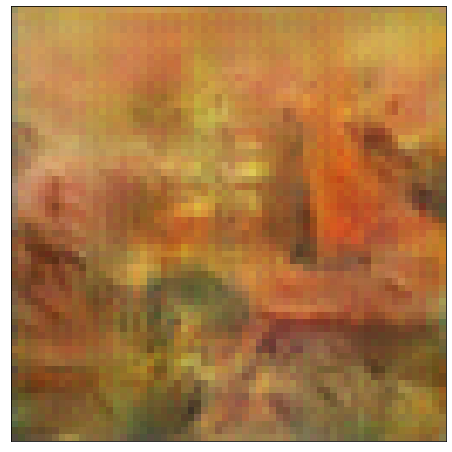

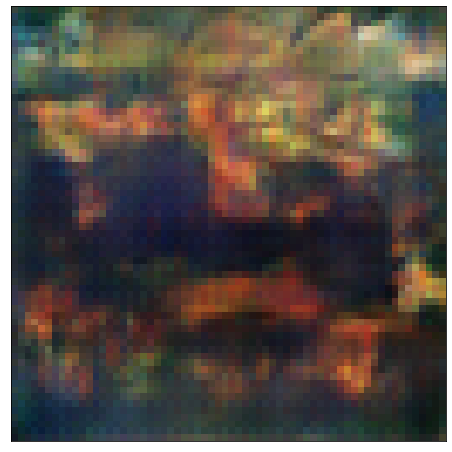

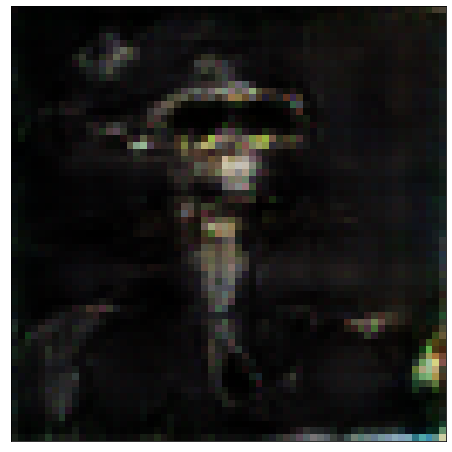

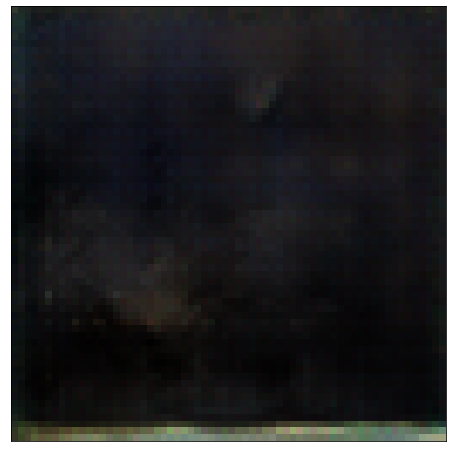

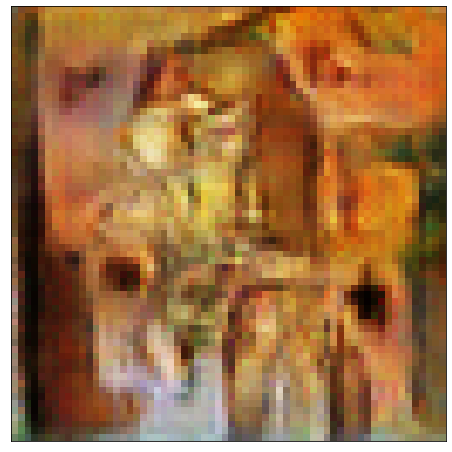

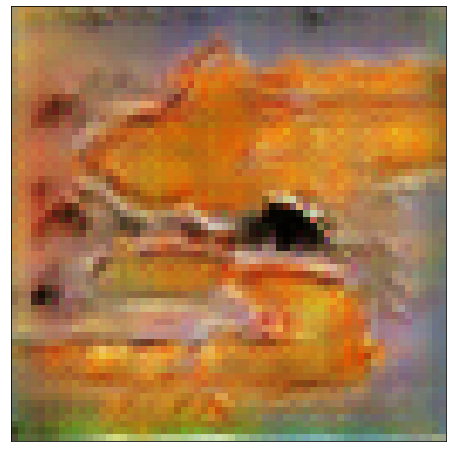

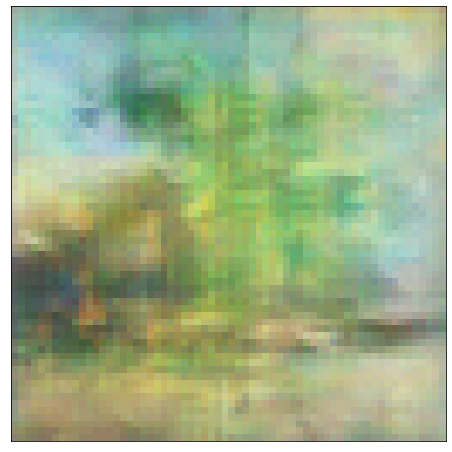

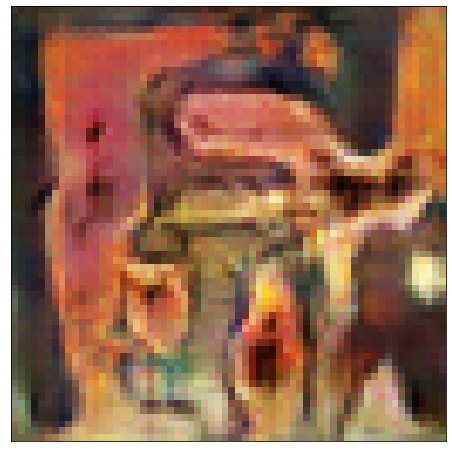

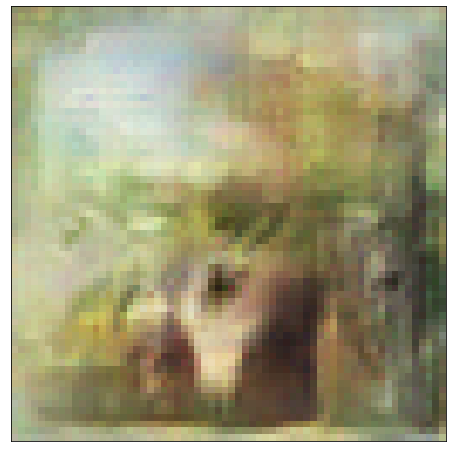

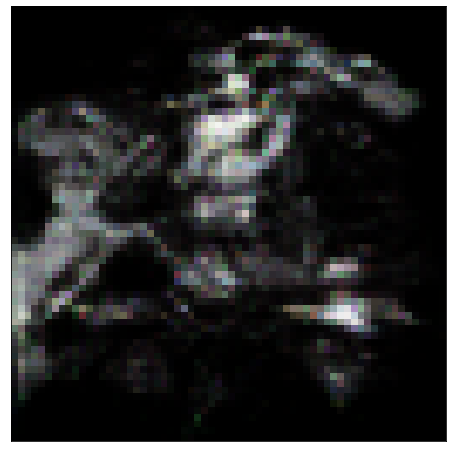

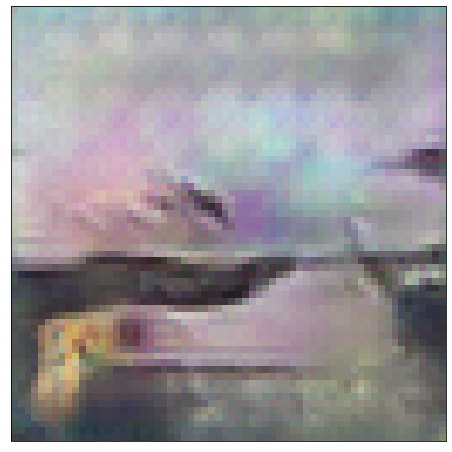

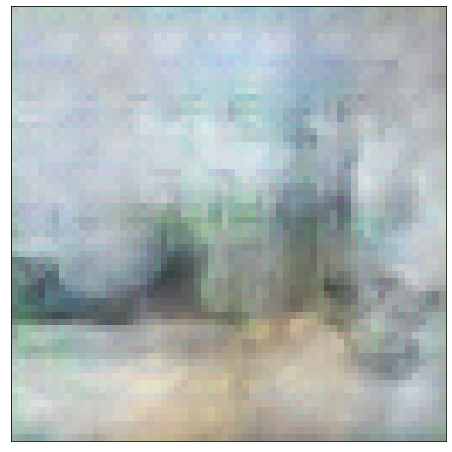

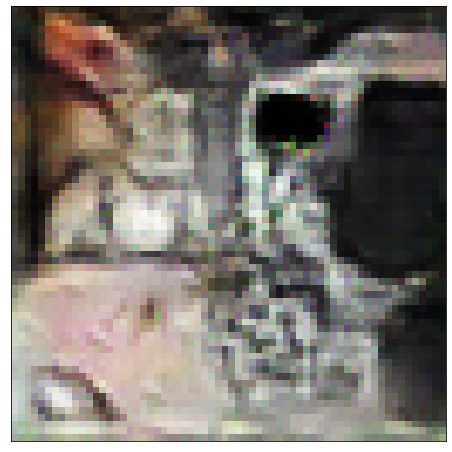

In [ ]:
if TEST:
    noise = torch.randn(num_imgs_to_generate, latent_dim, 1, 1)
    fake_images = generator.forward(noise.to(device)).to('cpu')
    print(fake_images.shape)
    for i in range(fake_images.shape[0]):
        show_images(fake_images[i,:,:,:])

torch.Size([128, 3, 64, 64])


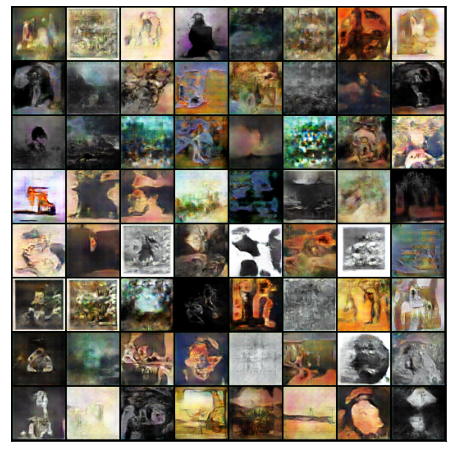

In [ ]:
if TEST:
    noise = torch.randn(num_imgs_to_generate, latent_dim, 1, 1)
    fake_images = generator.forward(noise.to(device)).to('cpu')
    print(fake_images.shape)
    show_images(fake_images)